In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Text Processing
import re

# load patient datasets
admissions = pd.read_csv("./clinical-database-data/ADMISSIONS.csv", index_col = None)
patients = pd.read_csv("./clinical-database-data/PATIENTS.csv", index_col = None)

# format the date as YYYY-MM-DD HH:MM:SS
admissions.admittime = pd.to_datetime(admissions.admittime, format ='%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.dischtime = pd.to_datetime(admissions.dischtime, format ='%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.deathtime = pd.to_datetime(admissions.deathtime, format ='%Y-%m-%d %H:%M:%S', errors = 'coerce')
patients['dob'] = pd.to_datetime(patients['dob'], format ='%Y-%m-%d %H:%M:%S', errors = 'coerce')


In [2]:
admissions.head(3)

row_id  subject_id  hadm_id           admittime           dischtime  \
0   12258       10006   142345 2164-10-23 21:09:00 2164-11-01 17:15:00   
1   12263       10011   105331 2126-08-14 22:32:00 2126-08-28 18:59:00   
2   12265       10013   165520 2125-10-04 23:36:00 2125-10-07 15:13:00   

            deathtime admission_type         admission_location  \
0                 NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
1 2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2 2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

  discharge_location insurance language  religion marital_status  \
0   HOME HEALTH CARE  Medicare      NaN  CATHOLIC      SEPARATED   
1       DEAD/EXPIRED   Private      NaN  CATHOLIC         SINGLE   
2       DEAD/EXPIRED  Medicare      NaN  CATHOLIC            NaN   

                ethnicity            edregtime            edouttime  \
0  BLACK/AFRICAN AMERICAN  2164-10-23 16:43:00  2164-10-23 23:00:00   
1   UNKNOWN/NOT SPECIFIED                  NaN                  NaN   
2   UNKNOWN/NOT SPECIFIED                  NaN                  NaN   

     diagnosis  hospital_expire_flag  has_chartevents_data  
0       SEPSIS                     0                     1  
1  HEPATITIS B                     1                     1  
2       SEPSIS                     1                     1

In [3]:
patients.head(3)

row_id  subject_id gender        dob                  dod  \
0    9467       10006      F 2094-03-05  2165-08-12 00:00:00   
1    9472       10011      F 2090-06-05  2126-08-28 00:00:00   
2    9474       10013      F 2038-09-03  2125-10-07 00:00:00   

              dod_hosp              dod_ssn  expire_flag  
0  2165-08-12 00:00:00  2165-08-12 00:00:00            1  
1  2126-08-28 00:00:00                  NaN            1  
2  2125-10-07 00:00:00  2125-10-07 00:00:00            1

In [4]:
# sort by subject_id and admitted time
admissions = admissions.sort_values(['subject_id','admittime'])

# 
admissions.reset_index(drop = True, inplace = True)


In [5]:
# calculate patient age
patient_age = {row[1]: row[2] for row in patients[['subject_id','dob']].itertuples()}
# add age to the df
admissions["age"] = [int((adm_time.date() - patient_age[subj_id].date()).days/365) for adm_time, subj_id in zip(admissions["admittime"], admissions["subject_id"])]

Text(0, 0.5, 'Count of Patients')

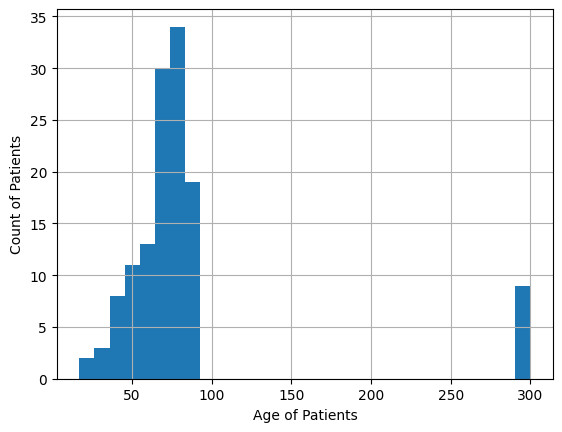

In [6]:
# Age histogram 

age_plot = admissions.age.hist(bins=30)
age_plot.set_xlabel('Age of Patients')
age_plot.set_ylabel('Count of Patients')

## Observations

The histogram shows that that more or less the age is spread up to 100, but there are
a some patients with an age of 300.

NB: patients with
age of over 89 are noted as 300 in the MIMIC 3 dataset due to HIPAA compliance.

#### fixing the age issue

 * scale ages of 300+ to 90's til 100 [reasons: more humanistic life span]

 * removing patients younger than 18 [reasons: better health, helps data to balance/even out the
readmission and non-readmission classes]


In [7]:
# scale down the ages with random numbers btween 90-100
admissions.loc[admissions.age >= 300,"age"] = random.choices(list(range(90,100)),k = sum(admissions.age >= 300))

In [8]:
# removing patients younger than 18
admissions = admissions[admissions.age >18]

Text(0, 0.5, 'Count of Patients')

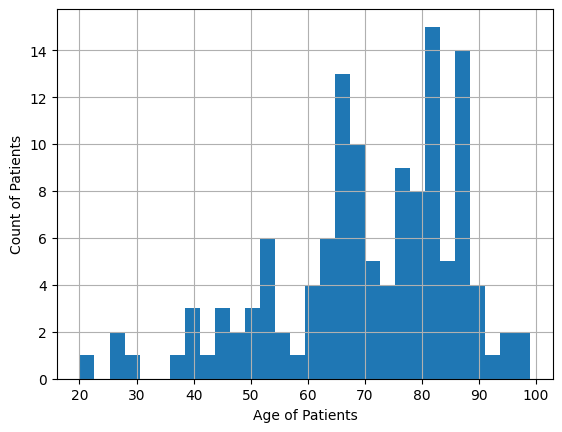

In [9]:
# Age histogram 

age_plot = admissions.age.hist(bins=30)
age_plot.set_xlabel('Age of Patients')
age_plot.set_ylabel('Count of Patients')

#### Ethnicity problem

Observations: Not enough of an even distribution, might clobber minorities [ affects precision]

<AxesSubplot: >

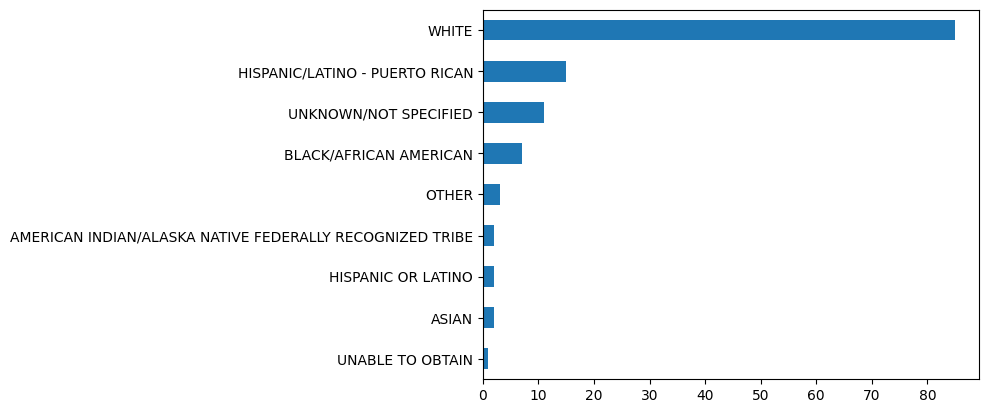

In [10]:
admissions.ethnicity.value_counts().head(10).sort_values().plot(kind = "barh")

#### Solution

-> Normalize ethnicity into fewer groups, and cluster minorities togther

In [11]:
def normalize_ethnicity(x):
    """
    Helper Function to Normalize Ethnicity into "WHITE", "HISPANIC","ASIAN", "BLACK" and "OTHERS"
    """
    if "WHITE" in x:
        return "WHITE"
    elif "HISPANIC" in x:
        return "HISPANIC"
    elif "ASIAN" in x:
        return "ASIAN"
    elif "BLACK" in x:
        "BLACK"
    else:
        return "OTHERS"

In [12]:
# current ethnic distribution

admissions.ethnicity.value_counts()

WHITE                                                       85
HISPANIC/LATINO - PUERTO RICAN                              15
UNKNOWN/NOT SPECIFIED                                       11
BLACK/AFRICAN AMERICAN                                       7
OTHER                                                        3
ASIAN                                                        2
HISPANIC OR LATINO                                           2
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
UNABLE TO OBTAIN                                             1
Name: ethnicity, dtype: int64

In [13]:
admissions.ethnicity = admissions.ethnicity.apply(lambda x: normalize_ethnicity(x) if pd.notnull(x) else x)

In [14]:
# Normalized ethnicity count
admissions.ethnicity.value_counts()

WHITE       85
OTHERS      17
HISPANIC    17
ASIAN        2
Name: ethnicity, dtype: int64

### Analysing admissions - discharge locations, discharge_duration

Observations
 * problem -> Just like ethnicity, uneven distribution might affect precision 
 * solution -> Club/group the different discharge chategoties (Normalize)

In [15]:
admissions.discharge_location.value_counts().head(10).sort_values().plot(kind = "barh")

<AxesSubplot: >

In [16]:
def normalize_discharge(x):
    """
    Helper Function to Normalize Discharge Location into "HOME","MEDICAL_FACILITY", and "OTHERS"
    """
    if "HOME" in x:
        return "HOME"
    elif len(re.findall("OTHER|DEAD",x)) > 0:
        return "OTHER"
    else:
        return "MEDICAL_FACILITY"

In [17]:
admissions.discharge_location = admissions.discharge_location.apply(lambda x: normalize_discharge(x) if pd.notnull(x) else x)

<AxesSubplot: >

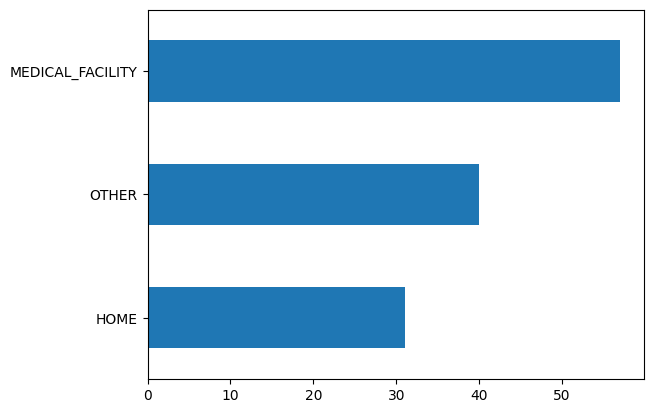

In [18]:
admissions.discharge_location.value_counts().head(10).sort_values().plot(kind = "barh")

In [19]:
# Calculate DISCHARGE_DURATION

admissions["discharge_duration"] = (admissions["dischtime"] - admissions["admittime"]).dt.total_seconds()/(24*60*60)

##### Whats the Plan Pro? 

-> get the value(readmission/no-readmission flag) to be predicted based on the number of days it takes to be re-admitted


HOW

 * shift the next admit time against last admit time.
 * subtract the discharge time from the next admit time to get days until next admission.

In [20]:
# Add the next Admit Time
admissions = admissions.sort_values(['subject_id','admittime'])

# make sure the admittime is sorted before the shift operation
admissions['next_admittime'] = admissions.groupby('subject_id').admittime.shift(-1)

In [21]:
# Subtract Discharge Time from Next Admit Time
admissions['days_next_admit']= (admissions.next_admittime - admissions.dischtime).dt.total_seconds()/(24*60*60)

admissions["is_readmission"] = admissions.days_next_admit.apply(lambda x: 0 if pd.isnull(x) else (0 if x >30 else 1))

###### NB: more exclusions

 * only unplanned medical carepatients
 * exclude newborns and/or ("ELECTIVE" and "NEWBORN")

In [22]:
admissions.admission_type.value_counts()

EMERGENCY    118
ELECTIVE       8
URGENT         2
Name: admission_type, dtype: int64

In [23]:
admissions = admissions[~admissions.admission_type.isin(["ELECTIVE","NEWBORN"])].reset_index(drop = True)

In [24]:
# remove any death related admissions (hospital_expire_flag)
# No readmision for the deceased

admissions = admissions[admissions.hospital_expire_flag == 0].reset_index(drop = True)

In [25]:
# Trim out features and and merge with patients_data using subject_id && gender

admissions = admissions[["subject_id", "hadm_id", "age", "admission_type","discharge_duration","discharge_location","insurance","ethnicity","is_readmission"]]

admissions = pd.merge(admissions, patients[["subject_id","gender"]],how="left", on = "subject_id")


In [26]:
admissions.tail()

subject_id  hadm_id  age admission_type  discharge_duration  \
75       44083   131048   54      EMERGENCY            2.911806   
76       44083   198330   54      EMERGENCY           10.045139   
77       44212   163189   45      EMERGENCY           36.011806   
78       44222   192189   73      EMERGENCY            1.253472   
79       44228   103379   58      EMERGENCY            9.615278   

   discharge_location insurance ethnicity  is_readmission gender  
75               HOME   Private     WHITE               1      M  
76               HOME   Private     WHITE               0      M  
77   MEDICAL_FACILITY  Medicare      None               0      F  
78               HOME  Medicare     WHITE               0      M  
79               HOME   Private     WHITE               0      F

#### Exploring ICU stays and trabsfers

In [27]:
icustays = pd.read_csv("./clinical-database-data/ICUSTAYS.csv", index_col = None)
transfers = pd.read_csv("./clinical-database-data/TRANSFERS.csv", index_col = None)

In [28]:
icustays.head()

row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0   12742       10006   142345      206504  carevue           MICU   
1   12747       10011   105331      232110  carevue           MICU   
2   12749       10013   165520      264446  carevue           MICU   
3   12754       10017   199207      204881  carevue            CCU   
4   12755       10019   177759      228977  carevue           MICU   

  last_careunit  first_wardid  last_wardid               intime  \
0          MICU            52           52  2164-10-23 21:10:15   
1          MICU            15           15  2126-08-14 22:34:00   
2          MICU            15           15  2125-10-04 23:38:00   
3           CCU             7            7  2149-05-29 18:52:29   
4          MICU            15           15  2163-05-14 20:43:56   

               outtime      los  
0  2164-10-25 12:21:07   1.6325  
1  2126-08-28 18:59:00  13.8507  
2  2125-10-07 15:13:52   2.6499  
3  2149-05-31 22:19:17   2.1436  
4  2163-05-16 03:47:04   1.2938

In [29]:
# Convert all the date columns
icustays.intime = pd.to_datetime(icustays.intime, format ='%Y-%m-%d %H:%M:%S', errors = 'coerce')
icustays.outtime = pd.to_datetime(icustays.outtime, format ='%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [30]:
transfers.dropna(subset=["icustay_id"], inplace = True)
transfers.icustay_id = transfers.icustay_id.astype(int)

 * it is possible for a patient to be transferred from one type of ICU to another and have the same ICUSTAY_ID. Therefore
 * To get the exact SUM of transfers for a particular ICUSTAYID, we use the TRANSFERS [eventtype] table.


In [31]:
transfers_num = transfers.groupby(["subject_id","hadm_id","icustay_id"])['eventtype'].apply(lambda x : sum(x=="transfer")).reset_index()
transfers_num.columns = ["subject_id","hadm_id","icustay_id", "num_transfers"]


In [32]:
# Updating ICU Data with number of transfer a patient undergoes once admitted
icustays = pd.merge(icustays, transfers_num, on=["subject_id","hadm_id","icustay_id"], how="left")


In [33]:
transfers_num.tail(3)

subject_id  hadm_id  icustay_id  num_transfers
133       44212   163189      239396              0
134       44222   192189      238186              0
135       44228   103379      217992              1

In [34]:
# Making sure that if a key (SUBJECT_ID,HADM_ID,"ICUSTAY_ID") is not found then 
#                            number of transfers for that key is set to 0
icustays['num_transfers'].fillna(0, inplace = True)
    

In [35]:
icustays.head(3)

row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0   12742       10006   142345      206504  carevue           MICU   
1   12747       10011   105331      232110  carevue           MICU   
2   12749       10013   165520      264446  carevue           MICU   

  last_careunit  first_wardid  last_wardid              intime  \
0          MICU            52           52 2164-10-23 21:10:15   
1          MICU            15           15 2126-08-14 22:34:00   
2          MICU            15           15 2125-10-04 23:38:00   

              outtime      los  num_transfers  
0 2164-10-25 12:21:07   1.6325              0  
1 2126-08-28 18:59:00  13.8507              0  
2 2125-10-07 15:13:52   2.6499              0

In [36]:
# ICU Transfers within 24hrs for a unique hospital admission
icustays_transfers_num = icustays.groupby(["subject_id","hadm_id"])["num_transfers"].sum().reset_index()

In [37]:
icustays_transfers_num

subject_id  hadm_id  num_transfers
0         10006   142345              0
1         10011   105331              0
2         10013   165520              0
3         10017   199207              1
4         10019   177759              0
..          ...      ...            ...
124       44083   198330              1
125       44154   174245              1
126       44212   163189              0
127       44222   192189              0
128       44228   103379              1

[129 rows x 3 columns]

In [38]:
# ICU Transfers across days (>24 hours) for a unique hospital admission
icustays_num = icustays.groupby(["subject_id","hadm_id"])["icustay_id"].nunique().reset_index()

icustays_num.columns = ["subject_id","hadm_id","icu_transfers"]


* Another important determinant of patient’s health during ICU STAYS can be LOS(length of stay) [ICUSTAYS table]

In [39]:
# Average Length of stay in ICU for a patient
icustays_avg_los = icustays.groupby(["subject_id","hadm_id"])["los"].mean().reset_index()

In [40]:
icustays = icustays.sort_values(["subject_id","hadm_id",'intime'])
icustays_firstcare = icustays.groupby(["subject_id","hadm_id"])['first_careunit'].nth(0).reset_index()


In [41]:
# Merge all the different dataframes on SUBJECT_ID, HADM_ID

import functools

In [42]:
_dfs = [icustays_num, icustays_avg_los, icustays_transfers_num, icustays_firstcare]

In [43]:
icustays_final = functools.reduce(lambda left,right: pd.merge(left,right,on=["subject_id","hadm_id"], how="inner"), _dfs)


In [44]:
icustays_final["total_transfers"] = icustays_final["icu_transfers"] + icustays_final["num_transfers"]

In [45]:
# Dorp all new_born icu stays / natal ward
icustays_final = icustays_final[~icustays_final.first_careunit.isin(["nicu","nward"])].reset_index(drop = True).drop(["num_transfers","icu_transfers"], axis = 1)
icustays_final

subject_id  hadm_id      los first_careunit  total_transfers
0         10006   142345   1.6325           MICU                1
1         10011   105331  13.8507           MICU                1
2         10013   165520   2.6499           MICU                1
3         10017   199207   2.1436            CCU                2
4         10019   177759   1.2938           MICU                1
..          ...      ...      ...            ...              ...
124       44083   198330   3.6174            CCU                2
125       44154   174245   0.6259           MICU                2
126       44212   163189  31.1235           MICU                1
127       44222   192189   1.3279            CCU                1
128       44228   103379   4.6191           SICU                2

[129 rows x 5 columns]

In [46]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Text Processing
import re





dictionary_itemid = pd.read_csv("./clinical-database-data/D_ITEMS.csv", index_col = None)
dictionary_itemid

dictionary_itemid.dropna(subset=["label"], inplace = True)

#### CHARTEVENTS.itemid ==> D_ITEMS.ID

# Take only those ITEM IDs which links to chart events
dictionary_itemid = dictionary_itemid[dictionary_itemid.linksto.isin(["chartevents"])]

# How to get the ITEMID's
# * Make a combination of words you expect to show up as description.
# * Use your domain knowledge to filter down the ITEMIDs

dictionary_itemid = pd.read_csv("./clinical-database-data/D_ITEMS.csv", index_col = None)
dictionary_itemid.dropna(subset=["label"], inplace = True)

dictionary_itemid[[ True if ("sys" in x.lower() and len(re.findall("bp|blood pressure|blood",x.lower())) > 0) else False for x in
dictionary_itemid.label]]
sys_bp_itemids = [51, 442, 6701, 220050, 220179]

dictionary_itemid[[ True if ("dia" in x.lower() and len(re.findall("bp|blood pressure|blood",x.lower())) > 0) else False for x in
dictionary_itemid.label]]
dia_bp_itemids = [8368, 8440, 8555, 220051, 220180]

dictionary_itemid[[ True if ("resp" in x.lower() and len(re.findall("rate",x.lower())) > 0) else False for x in dictionary_itemid.
label]]
respr_itemids = [615, 618, 3603, 224690, 220210]

dictionary_itemid[[ True if ("glucose" in x.lower()) else False for x in dictionary_itemid.label]]
glucose_itemids = [1455, 1310, 807, 811, 3744, 3745, 1529, 2338,225664, 220621, 226537]

heartrate_itemids = [211, 220045]
temp_itemids = [676, 678, 223761, 223762]

hadm_filter = icustays_final.hadm_id.tolist()
total_itemids = sys_bp_itemids+dia_bp_itemids+respr_itemids+glucose_itemids+temp_itemids+heartrate_itemids
n_rows = 100000



In [47]:
# create the iterator
chartevents_iterator = pd.read_csv("./clinical-database-data/CHARTEVENTS.csv",iterator=True,chunksize=n_rows,
usecols = ["subject_id", "hadm_id", "icustay_id", "itemid","value", "valuenum", "valueuom"])


In [48]:
# concatenate according to a filter to get our labevents data
chartevents = pd.concat([chartevent_chunk[np.logical_and(chartevent_chunk['hadm_id'].isin(hadm_filter), \
     chartevent_chunk['itemid'].isin(total_itemids))]  \
    if str(chartevent_chunk.hadm_id.dtype) == 'int64' \
    else chartevent_chunk[np.logical_and(chartevent_chunk['hadm_id'].isin([float(x) for x in hadm_filter]), \
    chartevent_chunk['itemid'].isin(total_itemids))] for chartevent_chunk in chartevents_iterator])

chartevents.dropna(axis = 0, subset = ["valuenum"], inplace = True)
chartevents.drop('value', axis = 1, inplace = True)


In [49]:
chartevents

subject_id  hadm_id  icustay_id  itemid  valuenum  valueuom
0            40124   126179    279554.0  223761      95.9        ?F
2            40124   126179    279554.0  220210      15.0  insp/min
3            40124   126179    279554.0  220045      94.0       bpm
4            40124   126179    279554.0  220179     163.0      mmHg
5            40124   126179    279554.0  220180      81.0      mmHg
...            ...      ...         ...     ...       ...       ...
477422       10130   156668    241562.0    8368      59.0      mmHg
477424       10130   156668    241562.0    8368      53.0      mmHg
477429       10130   156668    241562.0    8368      55.0      mmHg
477431       10130   156668    241562.0    8368      51.0      mmHg
477436       10130   156668    241562.0    8368      58.0      mmHg

[65735 rows x 6 columns]

In [50]:
# ensure that data is collected from the 2 systems for each of the patient's clinical data

In [51]:
print("Systolic BP  :- ", chartevents[chartevents.itemid.isin(sys_bp_itemids)].valueuom.unique())
print("Diastolic BP  :- ",chartevents[chartevents.itemid.isin(dia_bp_itemids)].valueuom.unique())
print("Respiratory Rate :- ",chartevents[chartevents.itemid.isin(respr_itemids)].valueuom.unique())
print("Glucose Levels   :- ",chartevents[chartevents.itemid.isin(glucose_itemids)].valueuom.unique())
print("Heart Rate    :- ",chartevents[chartevents.itemid.isin(heartrate_itemids)].valueuom.unique())
print("Temperature   :- ",chartevents[chartevents.itemid.isin(temp_itemids)].valueuom.unique())

Systolic BP  :-  ['mmHg']
Diastolic BP  :-  ['mmHg']
Respiratory Rate :-  ['insp/min' 'BPM']
Glucose Levels   :-  ['mg/dL' nan]
Heart Rate    :-  ['bpm' 'BPM']
Temperature   :-  ['?F' '?C' 'Deg. F' 'Deg. C']


#### Observation

1. insp/min is same as BPM, so no conversion is required here
2. no need to impute for NA in Glucose as the value is in the same range as when the unit is present.
3. must convert F to Celcious/d

### more clean up

* replacing the /itemids/ by their descriptive labels to aid readability and 
* also making them refer to a single category

In [52]:
# Replace ItemIds by their respective Chart Event Names to aid readability
mapping = {"Systolic_BP":sys_bp_itemids,
            "Diastolic_BP":dia_bp_itemids,
            "Resp_Rate":respr_itemids,
            "Glucose":glucose_itemids,
            "Heart_Rate":heartrate_itemids,
            "Temperature":temp_itemids}
item_id_map = {item_id: k for k,v in mapping.items() for item_id in v} 
chartevents["itemid"] = chartevents["itemid"].replace(item_id_map)

In [53]:
# convert Fahrenheit to Celsius
## NOTE: there has to be a better way? 

cond1 = np.logical_and(np.logical_or(chartevents["valueuom"] == "?F", chartevents["valueuom"] == "Deg. F"), \
                       pd.notnull(chartevents["valueuom"])).tolist()
                                     
cond2 = np.logical_or(chartevents["valueuom"] != "?F", chartevents["valueuom"] != "Deg. F").tolist()                                    
                                     
# condval1 = ((chartevents["valueuom"]-32)*5/9).tolist()  

# condval2= chartevents["valueuom"].tolist()

# chartevents["valueuom"] = np.select([cond1, cond2], [condval1,condval2])
                                     

In [54]:
chartevents["valueuom"][:2]

/tmp/ipykernel_23740/945074733.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  chartevents["valueuom"][:2]


0          ?F
2    insp/min
Name: valueuom, dtype: object

### standardized charts (EDA)

mean -> measure of central tendency
standard deviation -> measure of variability

In [55]:
charts = chartevents.pivot_table(index=['subject_id', 'hadm_id'],columns='itemid', values='valuenum', aggfunc=[np.mean, np.std]).reset_index()


In [56]:
charts.columns = charts.columns.get_level_values(0)+'_'+charts.columns.get_level_values(1)

Caution: the number of nulls for standard deviation columns would be larger than
mean columns since there are a lot of single values for a HADM_ID, but the difference is
not much,

In [57]:
print("""
SUBJECT_ID_          0
HADM_ID_            0
mean_Diastolic_BP   10988
mean_Glucose        610
mean_Heart_Rate      111
mean_Resp_Rate       134
mean_Systolic_BP    10981
mean_Temperature      241
std_Diastolic_BP   11215
std_Glucose       2557
std_Heart_Rate      121
std_Resp_Rate       173
std_Systolic_BP   11212
std_Temperature     687
""")


SUBJECT_ID_          0
HADM_ID_            0
mean_Diastolic_BP   10988
mean_Glucose        610
mean_Heart_Rate      111
mean_Resp_Rate       134
mean_Systolic_BP    10981
mean_Temperature      241
std_Diastolic_BP   11215
std_Glucose       2557
std_Heart_Rate      121
std_Resp_Rate       173
std_Systolic_BP   11212
std_Temperature     687



correcting nulls by backfilling with values from the last admission visit

In [58]:
charts = charts.groupby(['subject_id_'], group_keys=True).apply(lambda x: x.bfill())

In [59]:
charts

subject_id_  hadm_id_  mean_Diastolic_BP  mean_Glucose  \
subject_id_                                                               
10006       0          10006    142345                NaN    104.400000   
10011       1          10011    105331                NaN    104.826087   
10013       2          10013    165520          36.388889    149.500000   
10017       3          10017    199207                NaN    183.454545   
10019       4          10019    177759          63.822222    176.857143   
...                      ...       ...                ...           ...   
44083       120        44083    198330          68.513761    121.777778   
44154       121        44154    174245          63.361111    177.000000   
44212       122        44212    163189          49.044369    130.107317   
44222       123        44222    192189          70.454545    137.166667   
44228       124        44228    103379          62.219178    120.210526   

                 mean_Heart_Rate  mean_Resp_Rate  mean_Systolic_BP  \
subject_id_                                                          
10006       0          82.000000       25.375000               NaN   
10011       1          82.398649       15.447458               NaN   
10013       2          92.146341       21.635294        101.375000   
10017       3          91.836735       26.479167               NaN   
10019       4          83.333333       30.226415         82.466667   
...                          ...             ...               ...   
44083       120       101.536842       20.547368        111.862385   
44154       121        73.437500       25.615385        101.666667   
44212       122        94.462916       24.654457         97.326136   
44222       123        58.088235       17.323529        145.121212   
44228       124        95.796610       24.632479        111.328767   

                 mean_Temperature  std_Diastolic_BP  std_Glucose  \
subject_id_                                                        
10006       0           98.599999               NaN    51.182028   
10011       1           97.776087               NaN    31.101332   
10013       2           39.085714          8.354059    21.920310   
10017       3           97.309091               NaN    45.277729   
10019       4           96.074999         11.144279    85.554641   
...                           ...               ...          ...   
44083       120         98.440000         10.981141    19.626371   
44154       121         99.233333         13.661526          NaN   
44212       122         97.986792          7.792531    24.598306   
44222       123         97.114286         15.931672    71.418252   
44228       124         99.462500         15.086186    17.846814   

                 std_Heart_Rate  std_Resp_Rate  std_Systolic_BP  \
subject_id_                                                       
10006       0         11.217223      18.476336              NaN   
10011       1         21.540892       4.105304              NaN   
10013       2         14.457363       5.165930        22.433274   
10017       3          7.232297       3.935596              NaN   
10019       4          4.587533       6.812436        17.050193   
...                         ...            ...              ...   
44083       120       11.354829       4.764158        13.681880   
44154       121       10.773137       7.084510        32.474166   
44212       122        8.790959       4.862059        11.648111   
44222       123       12.141508       4.005455        20.531618   
44228       124       19.032837       5.378114        15.418802   

                 std_Temperature  
subject_id_                       
10006       0           0.818535  
10011       1           0.867530  
10013       2          10.177046  
10017       3           1.243748  
10019       4           1.281926  
...                          ...  
44083       120         0.626939  
44154       121         1.001665  
44212       122        

## Lab Events

PLAN: 
1. find ITEMSID corresponding with lab events (easier to focus on specific data)

In [60]:
hadm_filter = icustays_final.hadm_id.tolist()
total_labitems = [51265, 51221, 50862, 50983, 50971, 50893]
n_rows = 100000

In [61]:
## ability to chunk data using iterator

labevents_iterator = pd.read_csv("./clinical-database-data/LABEVENTS.csv", iterator=True, chunksize=n_rows)

In [62]:
# concatenate according to a filter(hadm_filter) to get labevents data

## SIMILAR TO CHARTEVENTS but with chunks from the lab DF (RUN ONCE)
labevents = pd.concat( \
    [labevent_chunk[np.logical_and(labevent_chunk['hadm_id'].isin(hadm_filter), \
                                                labevent_chunk['itemid'].isin(total_labitems))] \
                        if str(labevent_chunk.hadm_id.dtype) == 'int64' \
     
                        else labevent_chunk[np.logical_and(labevent_chunk['hadm_id'].isin([float(x) \
                        
                        for x in hadm_filter]),labevent_chunk['itemid'].isin(total_labitems))] \
                                    for labevent_chunk in labevents_iterator])


In [63]:
labevents

row_id  subject_id   hadm_id  itemid            charttime value  \
635     6245200       10006  142345.0   50862  2164-10-23 17:38:00   3.4   
642     6245207       10006  142345.0   50893  2164-10-23 17:38:00   9.4   
651     6245216       10006  142345.0   50971  2164-10-23 17:38:00   6.0   
654     6245219       10006  142345.0   50983  2164-10-23 17:38:00   139   
659     6245224       10006  142345.0   51221  2164-10-23 17:38:00  42.4   
...         ...         ...       ...     ...                  ...   ...   
76054  20452664       44228  103379.0   50983  2170-12-23 04:36:00   138   
76056  20452666       44228  103379.0   51221  2170-12-23 04:36:00  25.5   
76061  20452671       44228  103379.0   51265  2170-12-23 04:36:00   536   
76065  20452675       44228  103379.0   51221  2170-12-24 04:09:00  24.2   
76070  20452680       44228  103379.0   51265  2170-12-24 04:09:00   595   

       valuenum valueuom      flag  
635         3.4     g/dL       NaN  
642         9.4    mg/dL       NaN  
651         6.0    mEq/L  abnormal  
654       139.0    mEq/L       NaN  
659        42.4        %       NaN  
...         ...      ...       ...  
76054     138.0    mEq/L       NaN  
76056      25.5        %  abnormal  
76061     536.0     K/uL  abnormal  
76065      24.2        %  abnormal  
76070     595.0     K/uL  abnormal  

[8692 rows x 9 columns]

In [76]:
# rename itemids with names
labevents_label = dictionary_labitemid[dictionary_labitemid.itemid.isin(total_labitems)]
item_id_map = dict(zip(labevents_label.itemid,labevents_label.label)) 
labevents["itemid"] = labevents["itemid"].replace(item_id_map)


NameError: name 'dictionary_labitemid' is not defined